# Variational AutoEncoder Prototype

In [216]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

# Data preprocessing

In [217]:
import pandas as pd
df = pd.read_csv('OCTDL_labels.csv');
df2 = pd.DataFrame(df, columns = ['file_name', 'disease'])
df2.to_csv('labels.csv')

In [ ]:
# hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
IMG_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 5

In [246]:
# Transforms for the training dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure single-channel grayscale
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder('OCTDL', transform=transform)

n_test = int(np.floor(0.3 * len(dataset)))
n_train = len(dataset) - n_test

train_ds, test_ds = random_split(dataset, [n_train, n_test])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Print dataset information
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of testing samples: {len(test_ds)}")

Number of training samples: 1445
Number of testing samples: 619


In [219]:
# Check the shape of the input image
for i, (x, _) in enumerate(train_dl):
    print(f"Image shape: {x.shape}")
    break

Image shape: torch.Size([32, 1, 64, 64])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10d23beb0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/Library/

In [247]:
x_dim = 1 * IMG_SIZE * IMG_SIZE # channels * width * height
hidden_dim = int(x_dim / 8)
latent_dim = int(x_dim / 128)

print(x_dim, hidden_dim, latent_dim)

4096 512 32


In [ ]:
mean, std = 0.0, 0.0
for images, _ in DataLoader(dataset, batch_size=BATCH_SIZE):
    images = images.view(images.size(0), -1)  # Flatten images
    mean += images.mean(1).sum(0)
    std += images.std(1).sum(0)

mean /= len(dataset)
std /= len(dataset)
print(f"Dataset Mean: {mean}")
print(f"Dataset Std: {std}")

Dataset Mean: -0.5214556455612183
Dataset Std: 0.3635524809360504


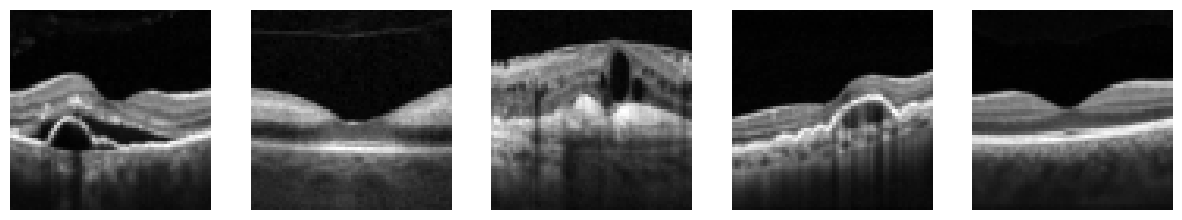

In [248]:
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img, _ = dataset[i]
        img = img.squeeze(0)  # Remove channel dimension for grayscale
        img = (img * 0.5) + 0.5  # De-normalize to [0, 1]
        axes[i].imshow(img.numpy(), cmap='gray')  # Use grayscale colormap
        axes[i].axis('off')
    plt.show()

# Show images from the training dataset
show_images(train_ds)

# Defining the model

In [253]:
# Encoder (with Conv layers)
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(IMG_SIZE * IMG_SIZE, 512)
        self.fc_mean = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        mean = self.fc_mean(x)
        log_var = self.fc_logvar(x)
        return mean, log_var

In [251]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, IMG_SIZE * IMG_SIZE)

    def forward(self, z):
        x = torch.nn.functional.leaky_relu(self.fc1(z))
        x = torch.sigmoid(self.fc2(x))
        return x.view(x.size(0), 1, IMG_SIZE, IMG_SIZE)

In [254]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, log_var):
        epsilon = torch.randn_like(log_var).to(DEVICE)  # Sampling epsilon        
        z = mean + torch.exp(0.5 * log_var) * epsilon  # Reparameterization trick
        return z
        
    def forward(self, x):
        mean, log_var = self.Encoder(x)  # Get latent parameters
        z = self.reparameterization(mean, log_var)  # Sample latent vector
        x_hat = self.Decoder(z)  # Reconstruct input
        return x_hat, mean, log_var

In [255]:
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [256]:
def loss_function(x, x_hat, mean, log_var):
    # Reconstruction loss (MSE for continuous data)
    reconstruction_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')

    # Kullback-Leibler Divergence (regularization term)
    kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
    # Normalize KLD by batch size to make it comparable to reconstruction_loss
    kld /= BATCH_SIZE
    return reconstruction_loss + kld

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

# Training the model

In [257]:
print("Start training VAE...")
model.train()
import time

for epoch in range(EPOCHS):
    overall_loss = 0
    epoch_start_time = time.time()
    for batch_idx, (x, _) in enumerate(tqdm(train_dl)):
        x = x.to(DEVICE)
        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        x_hat = torch.clamp(x_hat, min=1e-7, max=1.0 - 1e-7)
        loss = loss_function(x, x_hat, mean, log_var)
        overall_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # clipping the gradient to prevent crazy vals

        optimizer.step()
        
    print(f"Epoch {epoch+1}/{EPOCHS} \tAverage loss: {(overall_loss / (batch_idx + 1)):.2f} \tTime: {time.time() - epoch_start_time:.2f}s")
    
print("Finish!!")

Start training VAE...


100%|██████████| 46/46 [00:23<00:00,  1.93it/s]


Epoch 1/10 	Average loss: 2.57 	Time: 23.82s


100%|██████████| 46/46 [00:24<00:00,  1.92it/s]


Epoch 2/10 	Average loss: 0.39 	Time: 24.02s


100%|██████████| 46/46 [00:23<00:00,  1.94it/s]


Epoch 3/10 	Average loss: 0.39 	Time: 23.74s


100%|██████████| 46/46 [00:23<00:00,  1.93it/s]


Epoch 4/10 	Average loss: 0.39 	Time: 23.82s


100%|██████████| 46/46 [00:23<00:00,  1.93it/s]


Epoch 5/10 	Average loss: 0.39 	Time: 23.84s


100%|██████████| 46/46 [00:23<00:00,  1.94it/s]


Epoch 6/10 	Average loss: 0.39 	Time: 23.75s


100%|██████████| 46/46 [00:24<00:00,  1.91it/s]


Epoch 7/10 	Average loss: 0.39 	Time: 24.09s


100%|██████████| 46/46 [00:23<00:00,  1.93it/s]


Epoch 8/10 	Average loss: 0.39 	Time: 23.81s


100%|██████████| 46/46 [00:23<00:00,  1.94it/s]


Epoch 9/10 	Average loss: 0.39 	Time: 23.76s


100%|██████████| 46/46 [00:23<00:00,  1.94it/s]

Epoch 10/10 	Average loss: 0.39 	Time: 23.69s
Finish!!


# Evaluation

In [260]:
def show_images(original, reconstructed, idx):
    # Ensure images are in (height, width, channels) format for matplotlib
    original = original[idx].squeeze().cpu().numpy() 
    reconstructed = reconstructed[idx].squeeze().detach().cpu().numpy() 

    # Clamp values to [0, 1] range for visualization
    original = np.clip(original, 0, 1)
    reconstructed = np.clip(reconstructed, 0, 1)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(reconstructed, cmap='gray')
    axes[1].set_title("Reconstructed")
    axes[1].axis("off")

    plt.show()


In [261]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} gradient mean: {param.grad.abs().mean()}")

Encoder.fc1.weight gradient mean: 5.48892487017838e-08
Encoder.fc1.bias gradient mean: 9.06832156033488e-08
Encoder.fc_mean.weight gradient mean: 4.6164395826053806e-06
Encoder.fc_mean.bias gradient mean: 4.7100464144023135e-05
Encoder.fc_logvar.weight gradient mean: 4.40567237092182e-06
Encoder.fc_logvar.bias gradient mean: 4.448546314961277e-05
Decoder.fc1.weight gradient mean: 3.870795808325056e-06
Decoder.fc1.bias gradient mean: 8.557120054319967e-06
Decoder.fc2.weight gradient mean: 2.61782613364403e-08
Decoder.fc2.bias gradient mean: 7.960293402220486e-08


In [ ]:
# Evaluate the model and display images
model.eval()
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_dl)):
        x = x.to(DEVICE)
        x_hat, _, _ = model(x) 
        show_images(x, x_hat, idx=0) 
        

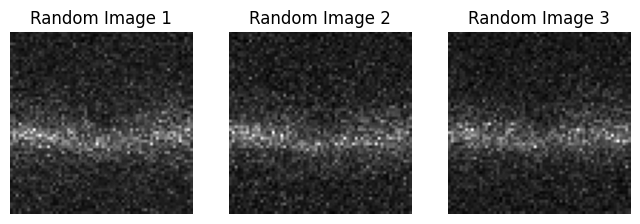

In [ ]:
def generate_from_random_noise(decoder, latent_dim, device, num_images=3):
    # Generate random noise (latent space vectors)
    noise = torch.randn(num_images, latent_dim).to(device)

    with torch.no_grad():
        reconstructed_images = decoder(noise) 

    fig, axes = plt.subplots(1, num_images, figsize=(8, 4))

    for i in range(num_images):
        img = reconstructed_images[i].squeeze().cpu().numpy()
        img = np.clip(img, 0, 1) 

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Random Image {i+1}")
        axes[i].axis("off")

    plt.show()

# Example usage:
generate_from_random_noise(decoder, latent_dim=latent_dim, device=DEVICE, num_images=3)